In [3]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize

# USER: Input path for .pkl files
target_dir = "C:\\Users\\fredr\\OneDrive\\Documents\\quail_volcano\\scenarios\\axisymmetric_test\\"
target_dir = "C:\\Users\\fredr\\Documents\\scratch\\axisymmetric_test\\"
# USER: Input path for Quail source code
source_dir = "C:\\Users\\fredr\\OneDrive\\Documents\\quail_volcano\\src\\"

In [4]:
# Import quail modules
os.chdir(source_dir)

import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphasevpT.atomics as atomics

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import multiprocessing as mp
import multidomain

os.chdir(target_dir)

### 1D analysis in air

0.6499999999999366
0.6499999999999366
0.6499999999999366


Text(0.5, 1.0, 'Exact: depends on abs difference from ideal density ratio (6)')

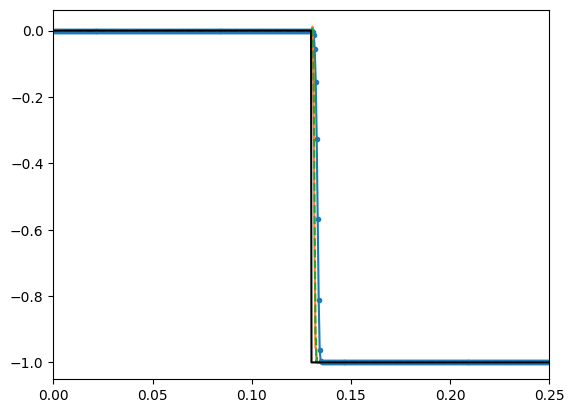

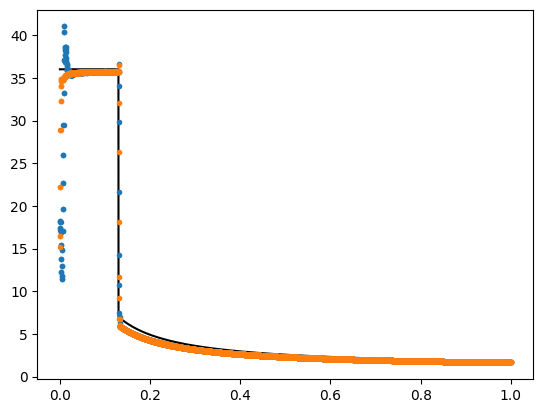

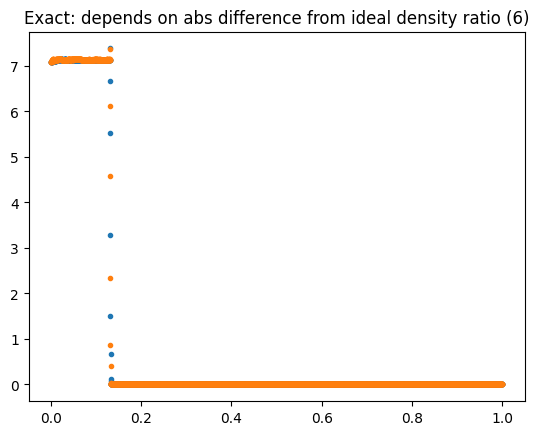

In [5]:
solver_from_p0 = lambda i: readwritedatafiles.read_data_file(f"noh_problem1D_e7N2000_{i}.pkl")
solver_from_p1 = lambda i: readwritedatafiles.read_data_file(f"noh_problem1D_e7N2000p1_{i}.pkl")
solver_from_p1c = lambda i: readwritedatafiles.read_data_file(f"noh_problem1D_e7N2000p1c1e3_{i}.pkl") # Wall correction
solver_from_p1n = lambda i: readwritedatafiles.read_data_file(f"noh_problem1D_e7N2000p1n_{i}.pkl") # No correction

for i in range(130, 131, 10): #range(200, 201, 10):
  solver_1D = solver_from_p0(i)
  x = solver_1D.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  r = x[:,:,0:1]
  p = solver_1D.physics.compute_variable("Pressure", solver_1D.state_coeffs)
  T = solver_1D.physics.compute_variable("Temperature", solver_1D.state_coeffs)
  u = solver_1D.physics.compute_variable("XVelocity", solver_1D.state_coeffs)
  # rho = solver_1D.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(r.ravel(), u.ravel(), '.-')
  print(solver_1D.time)

  solver_1D = solver_from_p1c(i)
  x = solver_1D.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  r = x[:,:,0:1]
  p = solver_1D.physics.compute_variable("Pressure", solver_1D.state_coeffs)
  T = solver_1D.physics.compute_variable("Temperature", solver_1D.state_coeffs)
  u = solver_1D.physics.compute_variable("XVelocity", solver_1D.state_coeffs)
  rho_p1c = solver_1D.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(r.ravel(), u.ravel(), '-')
  print(solver_1D.time)

  solver_1D = solver_from_p1(i)
  x = solver_1D.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  r = x[:,:,0:1]
  p_p1 = solver_1D.physics.compute_variable("Pressure", solver_1D.state_coeffs)
  T = solver_1D.physics.compute_variable("Temperature", solver_1D.state_coeffs)
  u = solver_1D.physics.compute_variable("XVelocity", solver_1D.state_coeffs)
  rho_p1 = solver_1D.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(r.ravel(), u.ravel(), '--')
  print(solver_1D.time)
plt.xlim(0,0.25)
# plt.xlim(0,0.025)

# Compute nondimensional variable
gamma = 1.4
us_analytic = (gamma-1)/2 * 1
eta = r / (us_analytic * solver_1D.time)
u_ref = np.where(eta <= 1, 0, -1)
plt.plot(r.ravel(), u_ref.ravel(), 'k')

plt.figure()
# Compute reference solution
rho_ref = np.where(eta <= 1, 36, (1 + 6/eta))
plt.plot(r.ravel(), rho_ref.ravel(), 'k')
plt.plot(r.ravel(), rho_p1.ravel(), '.')
plt.plot(r.ravel(), rho_p1c.ravel(), '.')

plt.figure()
# Density compression ratio
_k = 6
p_ref = np.where(eta <= 1,
  1e-5 * (_k + 0.5*(gamma-1) * (_k - 1)) / (1 -  0.5*(gamma-1) * (_k - 1)),
  0)
# plt.plot(r.ravel(), p_ref.ravel(), 'k')
plt.plot(r.ravel(), p_p1.ravel(), '.')
plt.plot(r.ravel(), p.ravel(), '.')
plt.title("Exact: depends on abs difference from ideal density ratio (6)")


In [175]:
# Boundary energy flux time-integral
vec_t = []
vec_bdry_rflux = []

for i in range(0,110,10):
  solver_1D = solver_from(i)
  x = solver_1D.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  E = solver_1D.state_coeffs[...,4:5]
  p = solver_1D.physics.compute_variable("Pressure", solver_1D.state_coeffs)
  T = solver_1D.physics.compute_variable("Temperature", solver_1D.state_coeffs)
  u = solver_1D.physics.compute_variable("XVelocity", solver_1D.state_coeffs)

  Eflux = (E + p) * u
  vec_t.append(solver_1D.time)
  vec_bdry_rflux.append((r_mean.ravel()[-1] * Eflux.ravel()[-1]))

In [176]:
np.array(vec_t), np.array(vec_bdry_rflux)
energy_bdry = scipy.integrate.cumtrapz(vec_bdry_rflux, x=vec_t)

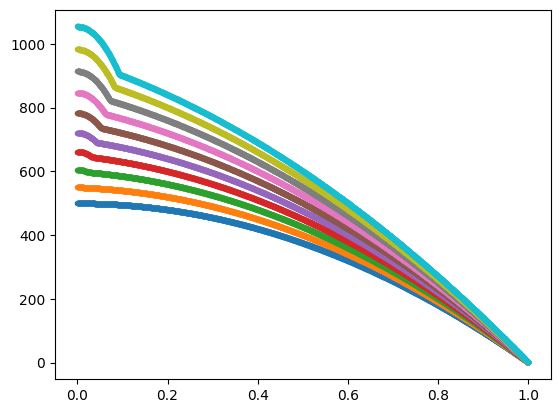

In [177]:
for i in range(0,100,10):
  solver_1D = solver_from(i)
  x = solver_1D.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  E = solver_1D.state_coeffs[...,4:5]
  p = solver_1D.physics.compute_variable("Pressure", solver_1D.state_coeffs)
  T = solver_1D.physics.compute_variable("Temperature", solver_1D.state_coeffs)
  u = solver_1D.physics.compute_variable("XVelocity", solver_1D.state_coeffs)

  Eflux = (E + p) * u
  # Reverse cumulative sum, minus r*flux at far boundary
  endiff = (r_mean * E)[::-1].cumsum()[::-1] - energy_bdry[i//10]
  plt.plot(r.ravel(), endiff.ravel(), '.-')

# plt.xlim(0,0.1)

# plt.plot(r.ravel(), endiff, '.')

In [178]:
bdry_Eflux

-0.5226421677062684

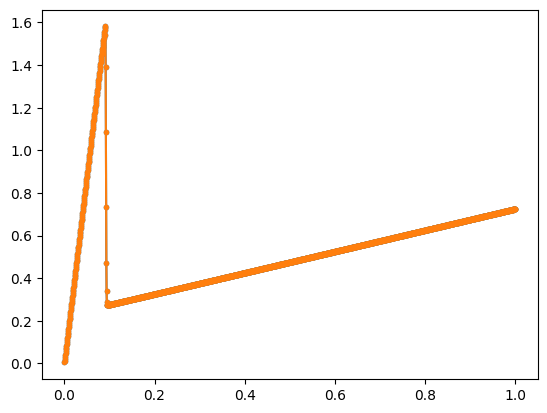

In [179]:

# plt.plot(r_mean.ravel(), E.ravel(), '.-')

# Boundary flux
# plt.plot(r_mean.ravel(), Eflux.ravel(), '.-')
# Boundary flux: last element value
bdry_Eflux = Eflux.ravel()[-1]

plt.plot(r_mean.ravel(), (r_mean * E).ravel(), '.-')
plt.plot(r_mean.ravel(), (r_mean * E).ravel(), '.-')
# bdry_Eflux = Eflux.ravel()[-1]


### Mixture 1D

In [380]:
1 / us_ref

55.22732596279061

t = 13.806831490695174
Velocity ratio chosen was 7.285046914694513, and rho/rho_inf should be 1 + W/eta
t = 13.80683149069273
Velocity ratio chosen was 7.285046914694513, and rho/rho_inf should be 1 + W/eta
t = 13.80683149070645
Velocity ratio chosen was 7.285046914694513, and rho/rho_inf should be 1 + W/eta


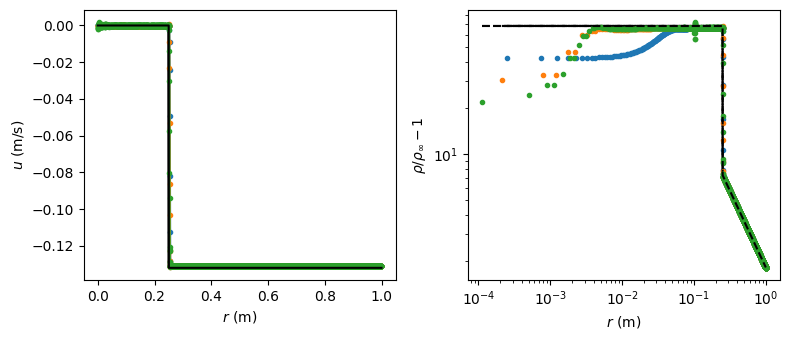

In [31]:
solver_from_mixture_p0 = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_1d_{i}.pkl")
solver_from_mixture_p1 = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_standard_1dp1_{i}.pkl")
solver_from_mixture_p2 = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_standard_1dp2ref_{i}.pkl")

loaders = [solver_from_mixture_p0,
           solver_from_mixture_p1,
           solver_from_mixture_p2]

# Adjustment factor for differences in dt
dt_adj_factor = [1, 2, 4]

plt.figure(1, figsize=(8,3.5), dpi=100)
for i, loader in enumerate(loaders):
  solver = loader(100 * dt_adj_factor[i])
  x = solver.elem_helpers.x_elems
  r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
  r = x[:,:,0:1]
  p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
  T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
  u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
  rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  print(f"t = {solver.time}")

  # Compute reference ODE system
  us_ref = 0.01810697843081792 # Computed from ODE system
  uinf_ref = -0.13191018735187018 # Computed from ODE system
  rho_compression_ratio_ref = 8.242880 # Computed from ODE system
  # Compute nondimensional variable
  eta = r / (us_ref * solver.time)
  u_ref = np.where(eta <= 1, 0, uinf_ref)
  # Velocity ratio from reference solution
  W = -uinf_ref / us_ref
  # Build asymptotic solution using reference parameters
  eta_trunc = r.ravel()[np.where(r.ravel() > us_ref * solver.time)]
  ref_rho_plaw_trunc = (W / eta).ravel()[np.where(r.ravel() > us_ref * solver.time)]
  eta_sub1 = np.array([r.ravel()[0], us_ref * solver.time])
  ref_rho_sub1 = rho_compression_ratio_ref * (1.0 + W) * np.ones_like([1, 1])
  eta_ref = np.concatenate([eta_sub1, eta_trunc,])
  rho_ref = np.concatenate([ref_rho_sub1, ref_rho_plaw_trunc,])
  print(f"Velocity ratio chosen was {W}, and rho/rho_inf should be 1 + W/eta")

  def cosort(r, f):
    ''' Ravel r, f and sort r, f(r). '''
    r_ravel = r.ravel()
    _i = np.argsort(r_ravel)
    return r_ravel[_i], f.ravel()[_i]

  # Subplot 1: r, u
  plt.subplot(1,2,1)
  plt.plot(*cosort(r, u), '.-')
  plt.plot(*cosort(r, u_ref), 'k-')
  plt.xlabel(r"$r$ (m)")
  plt.ylabel(r"$u$ (m/s)")

  # Subplot 2: r, N - 1
  plt.subplot(1,2,2)
  plt.loglog(*cosort(r, rho - 1), '.')
  plt.loglog(eta_ref, rho_ref, 'k--')
  plt.loglog(*cosort(np.array([r.ravel()[0], us_ref * solver.time]),
                    rho_compression_ratio_ref * (1.0 + W) * np.ones_like([1, 1])), 'k--')
  plt.xlabel(r"$r$ (m)")
  plt.ylabel(r"$\rho / \rho_\infty - 1$")

plt.tight_layout();

Velocity ratio chosen was 7.242880371660855, and rho/rho_inf should be 1 + W/eta


Text(0, 0.5, '$\\rho / \\rho_\\infty - 1$')

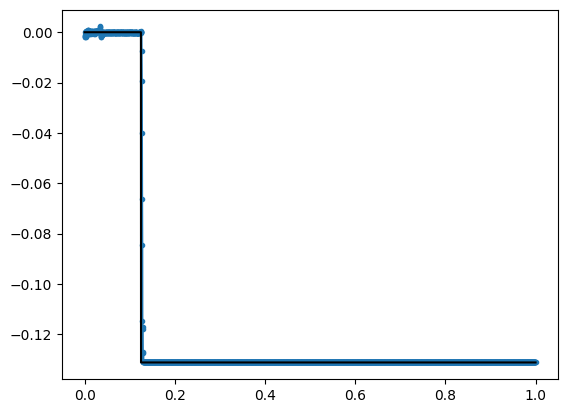

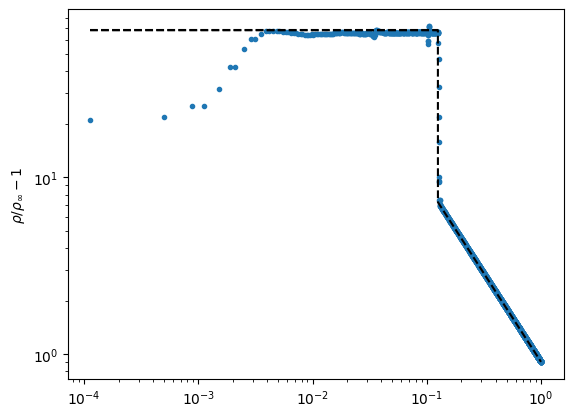

#### 2D

In [405]:
x_ds, p_ds = mdtools.downsample(solver, "Pressure")

In [408]:
# %matplotlib tk
# mdtools.plot_mean(x_ds, p_ds, (0, 1))

In [492]:
# solver_from_mixture_2D = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_nondilute_2d_{i}.pkl")
solver_from_mixture_2D = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_1dp1_{i}.pkl")
solver_from_mixture_2D_p0 = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_{i}.pkl")
solver_from_mixture_2D = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_standard_1dp1_{i}.pkl")

solver = solver_from_mixture_2D_p0(30) #(60)
rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
x = solver.elem_helpers.x_elems
r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
r = x[:,:,0:1]
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
# v = solver.physics.compute_variable("YVelocity", solver.state_coeffs)
print(solver.time)

solver = solver_from_mixture_2D(30) #(60)
rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
x = solver.elem_helpers.x_elems
r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
r = x[:,:,0:1]
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
print(solver.time)

0.0003000000000000064
2.0710247236047463


Velocity ratio chosen was 7.242880371660855, and rho/rho_inf should be 1 + W/eta


Text(0, 0.5, '$\\rho / \\rho_\\infty - 1$')

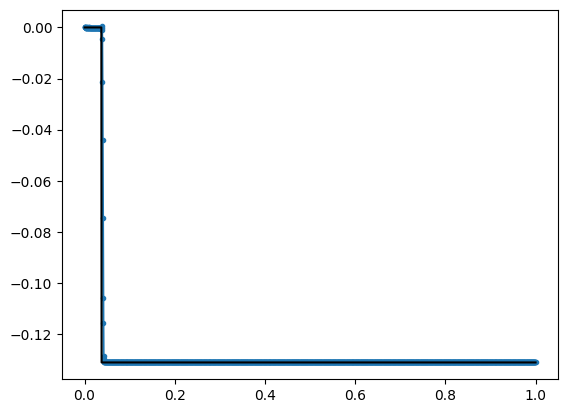

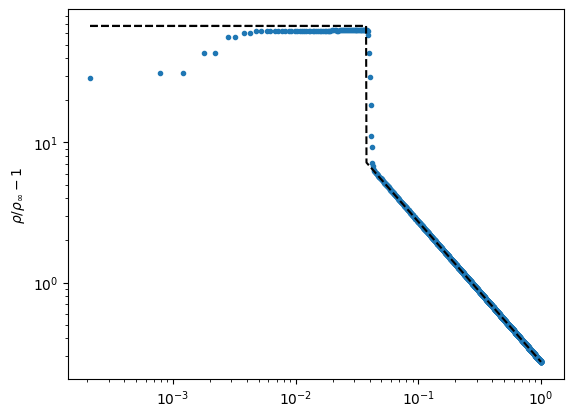

In [490]:
%matplotlib inline
us_ref = 0.01810697843081792 # Computed from ODE system
uinf_ref = -0.13114667866665758 # Computed from ODE system
rho_compression_ratio_ref = 8.242880 # Computed from ODE system
# Velocity ratio from reference solution
W = -uinf_ref / us_ref
# Compute nondimensional variable
eta = r / (us_ref * solver.time)
u_ref = np.where(eta <= 1, 0, uinf_ref)
print(f"Velocity ratio chosen was {W}, and rho/rho_inf should be 1 + W/eta")

def cosort(r, f):
  ''' Ravel r, f and sort r, f(r). '''
  r_ravel = r.ravel()
  _i = np.argsort(r_ravel)
  return r_ravel[_i], f.ravel()[_i]

plt.plot(*cosort(r, u), '.-')
plt.plot(*cosort(r, u_ref), 'k-')
plt.figure()
plt.loglog(*cosort(r, rho - 1), '.')

# Build asymptotic solution using reference parameters
eta_trunc = r.ravel()[np.where(r.ravel() > us_ref * solver.time)]
ref_rho_plaw_trunc = (W / eta).ravel()[np.where(r.ravel() > us_ref * solver.time)]
eta_sub1 = np.array([r.ravel()[0], us_ref * solver.time])
ref_rho_sub1 = rho_compression_ratio_ref * (1.0 + W) * np.ones_like([1, 1])
eta_ref = np.concatenate([eta_sub1, eta_trunc,])
rho_ref = np.concatenate([ref_rho_sub1, ref_rho_plaw_trunc,])

plt.loglog(eta_ref, rho_ref, 'k--')
plt.loglog(*cosort(np.array([r.ravel()[0], us_ref * solver.time]),
                   rho_compression_ratio_ref * (1.0 + W) * np.ones_like([1, 1])), 'k--')
plt.ylabel(r"$\rho / \rho_\infty - 1$")

In [290]:
solver_from = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute2_{i}.pkl")
solver_from = lambda i: readwritedatafiles.read_data_file(f"noh_problem_e5_{i}.pkl")
solver_from = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_2d_{i}.pkl")
solver_from = lambda i: readwritedatafiles.read_data_file(f"noh_mixture_dilute_1d_{i}.pkl")

In [336]:
shock_loc_approx

array([[0.2075]])

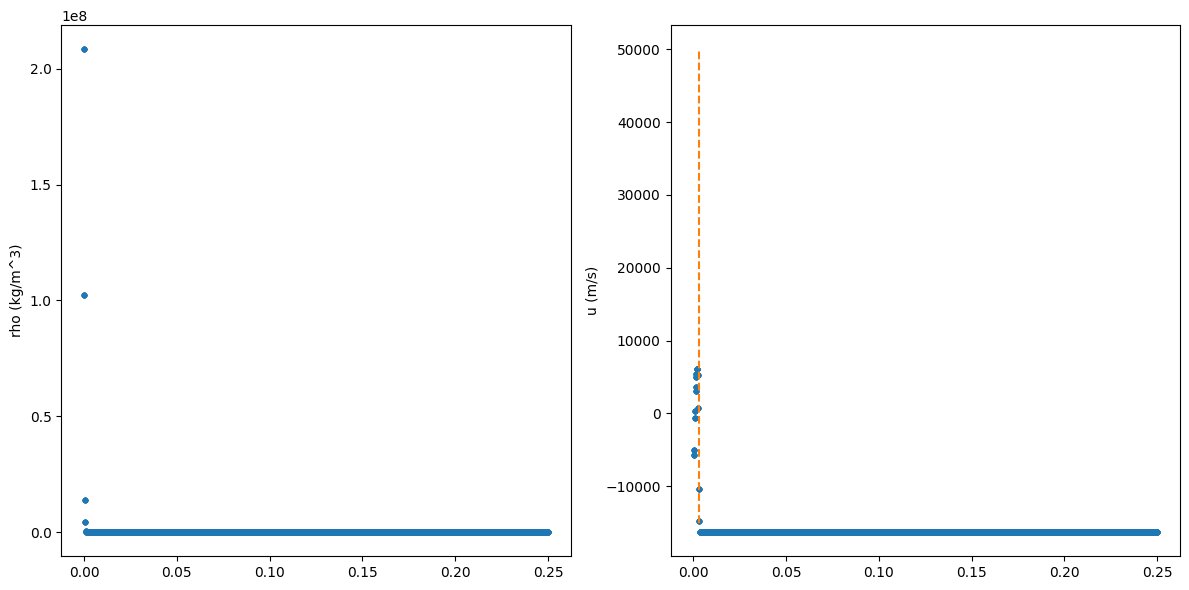

In [348]:
solver = solver_from(1)
x = solver.elem_helpers.x_elems
r_mean = x[:,:,0:1].mean(axis=1,keepdims=True)
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)
rho =  solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
# Max u-gradient front detection
_i = np.argmax(np.diff(u.ravel())**2)
r_faces = 0.5*(r_mean[1:] + r_mean[:-1])
shock_loc_approx = float(r_faces[_i])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(r_mean.ravel(), rho.ravel(), '.')
plt.ylabel("rho (kg/m^3)")
plt.subplot(1,2,2)
plt.plot(r_mean.ravel(), u.ravel(), '.')
plt.ylabel("u (m/s)")
plt.plot(shock_loc_approx*np.array([1, 1]), np.array([-1.5e4, 5e4]), '--')
plt.tight_layout()

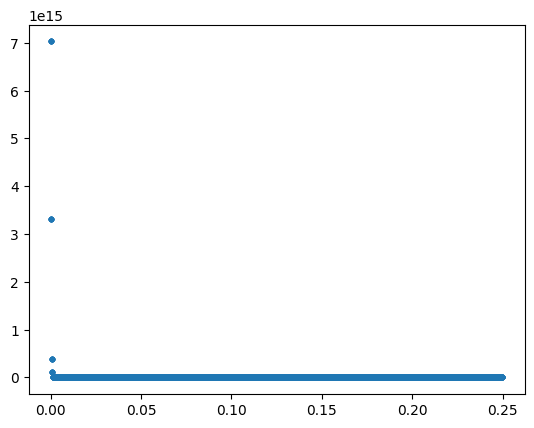

In [349]:
plt.plot(r_mean.ravel(), p.ravel(), '.')

In [343]:
us_approx = shock_loc_approx / solver.time
print(f"shock speed: {us_approx}")

shock speed: 41499.999999998705


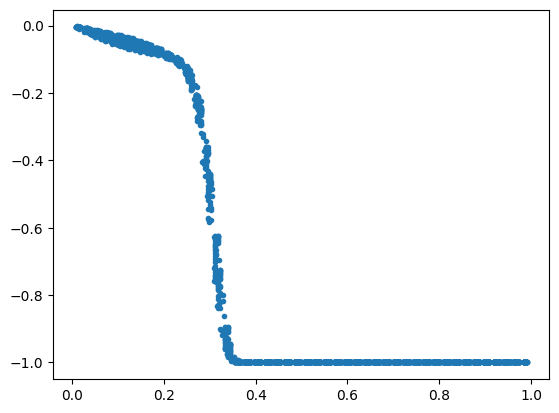

In [112]:
solver = solver_from(160)

U = solver.state_coeffs
rho = U[...,0:3].sum(axis=-1, keepdims=True)
u = U[...,3:4] / rho
v = U[...,4:5] / rho
p = solver0.physics.compute_variable("Pressure", solver.state_coeffs)
T = solver0.physics.compute_variable("Temperature", solver.state_coeffs)

# plt.plot(r_mean.ravel(), (v/u).ravel(), '.')
plt.plot(r_mean.ravel(), (u).ravel(), '.')

In [100]:
2.4/.4

5.999999999999999

C:\Users\fredr\AppData\Local\Temp\ipykernel_23224\2367355797.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(plt.cm.ScalarMappable(


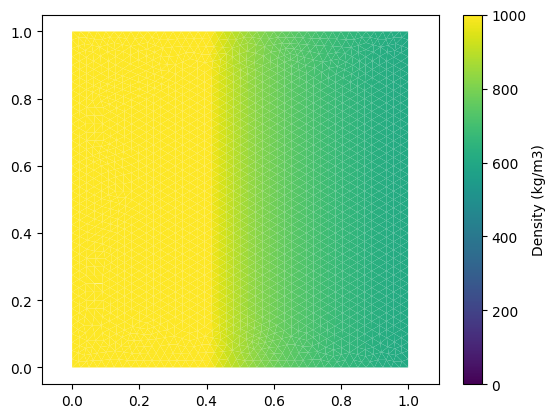

In [114]:
''' 2D visualization '''
x, p = mdtools.downsample(solver, "Pressure")
rho = solver.state_coeffs[..., 0:3].sum(axis=-1, keepdims=True)
mdtools.plot_mean(x, rho, (0, 3))

clims = (0,1000)
cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("Density (kg/m3)")


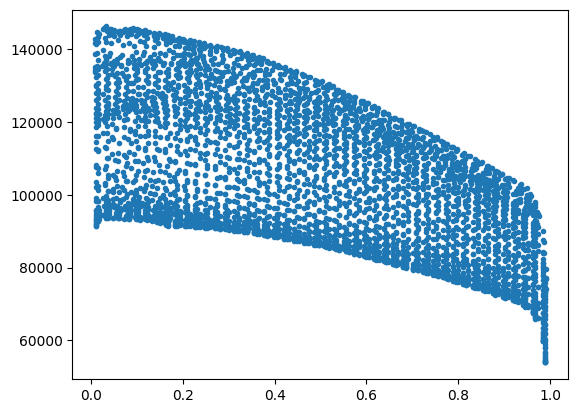

### Scratch

In [357]:
import scipy.special

def crystal_enhancement(phi):
  ''' phi = arhoC / arhoM is the crystal vol frac of magma. 
  This means mass of crystal per mass of magma (melt + dissolved water + crystal)'''
  
  alpha = 0.999916
  phi_cr = 0.673
  gamma = 3.98937
  delta = 16.9386
  B = 2.5

  phi_ratio = phi / phi_cr
  AA = np.sqrt(np.pi) / (2 * alpha)
  erf = scipy.special.erf(AA * phi_ratio * (1 + phi_ratio**gamma))

  num = 1 + phi_ratio**delta
  denom = (1 - alpha * erf)**(-B * phi_cr)
  crysVisc = num * denom

  return crysVisc

(1, 10000000000.0)

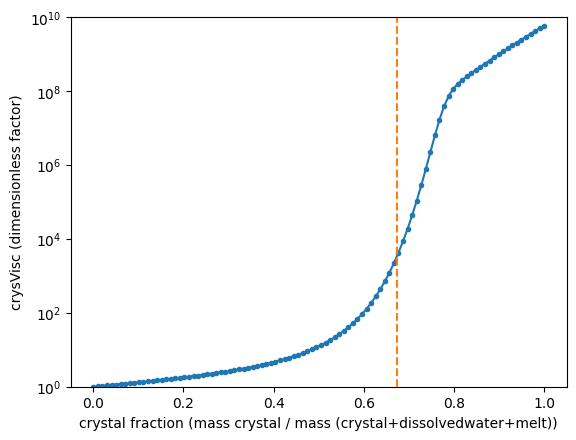

In [365]:
plt.semilogy(np.linspace(0, 1, 100),
             crystal_enhancement(np.linspace(0, 1, 100)), '.-')
plt.plot([0.673, 0.673], [1, 1e10], '--')
plt.xlabel("crystal fraction (mass crystal / mass (crystal+dissolvedwater+melt))")
plt.ylabel(r"crysVisc (dimensionless factor)")
plt.ylim(1, 1e10)

### Legacy

c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.600048e-01
  warnings.warn(
c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.106442e-01
  warnings.warn(
c:\Users\fredr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadrature.py:372: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.703708e-01
  warnings.warn(


Text(0, 0.5, 'u_mid (m/s)')

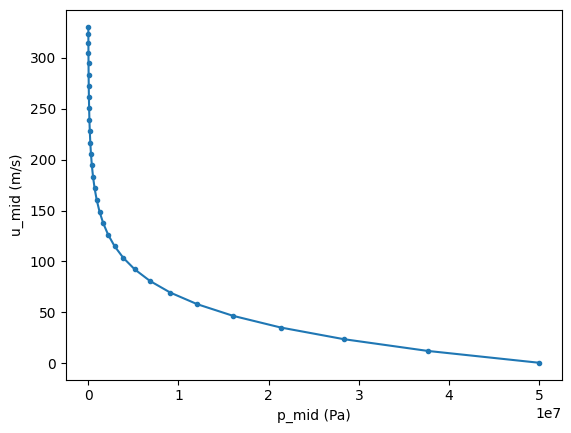

In [4]:
''' Show expansion wave solution with velocity as a function of final expansion pressure '''

# Extract L state, parameters
physics = solver0.physics
arhoVecL = UL[:,:, physics.get_mass_slice()]
volEnergyL = UL[..., physics.get_state_slice("Energy")]
momentumZeros = np.zeros_like(volEnergyL)
K, rho0, p0 = \
  physics.Liquid["K"], physics.Liquid["rho0"], physics.Liquid["p0"]

# Compute L state dependents
T_L = atomics.temperature(arhoVecL, momentumZeros, volEnergyL, physics)
p_L = atomics.pressure(arhoVecL, T_L,
  atomics.gas_volfrac(arhoVecL, T_L, physics), physics)
Gamma = atomics.Gamma(arhoVecL, physics)
S_L = T_L / p_L**((Gamma-1)/Gamma)
y = atomics.massfrac(arhoVecL)
yRGas = y[...,0] * physics.Gas[0]["R"] + y[...,1] * physics.Gas[1]["R"]

def ruT_p(p:float) -> tuple: 
  ''' Compute (rho, u, T) as a function of p, expanding from fixed UL. '''
  normals = np.array([1])
  _, u_expanded, T_expanded = atomics.velocity_RI_fixed_p_quadrature(p, UL[0:1,0:1,:],
    physics, normals, is_adaptive=True, tol=1e-1, rtol=1e-3)
  rho_expanded = 1.0 / atomics.mixture_spec_vol(y, p, T_expanded, physics)
  return float(rho_expanded), float(u_expanded), float(T_expanded)

# Compute density
p_series = np.geomspace(1e4, 50e6, 31)
rho_series = [ruT_p(p)[1] for p in p_series]
plt.plot(p_series, rho_series, '.-')
plt.xlabel("p_mid (Pa)")
plt.ylabel("u_mid (m/s)")

In [5]:
''' Grid-search shock speed sigma, post-shock pressure pP == pE for lowest residual of Rankine-Hugoniot momentum & energy conditions. '''
physics = solver0.physics

def compute_RH_residual(sigma, pE, return_norm_only=True):
  ''' Based on guess on shock speed and expanded pressure,
  compute the Rankine-Hugoniot momentum and energy residuals.
  
  Using expanded pressure pE, the expansion wave is computed,
  which gives the velocity uE. The match condition at the contact
  implies (p, u)_P = (p, u)_E. From Rankine-Hugoniot mass, the
  density rho_P is constrained. The residual for the remaining
  Rankine-Hugoniot conditions (momentum, energy) are returned.

  The returned residuals are written in form fP / fR - 1, where
  fP is the flux on the post-shock side, fR is the flux on the right
  (prescribed) side.
  '''
  # Expanded state Es
  rhoE, uE, TE = ruT_p(pE)
  # Post-shock state P
  uP = uE
  pP = pE
  # Rankine-Hugoniot mass
  rhoP = rhoR * (uR - sigma) / (uP - sigma)
  # Rankine-Hugoniot momentum, residual
  momentumfluxR = rhoR * (uR - sigma)*(uR - sigma) + pR
  momentumfluxP = rhoP * (uP - sigma)*(uP - sigma) + pP

  # Compute rhom(p)
  rhomP = physics.Liquid["rho0"] * (1 + (pP - physics.Liquid["p0"]) / physics.Liquid["K"])
  # Mass fraction vector of post-shock (P) state
  yP = yR.ravel()
  # Mass fraction of magma, post-shock (P) state
  ymP = yP[2]
  # Gas specific volume of post-shock(P) state
  vgasP = (1 / rhoP - ymP /rhomP) / (yP[0] + yP[1])
  # Ideal gas constant of mixed gas
  RgasP = (yP[0] * physics.Gas[0]["R"]
          + yP[1] * physics.Gas[1]["R"]) / (yP[0] + yP[1])
  # Temperature of post-shock (P) state
  TP = pP * vgasP / RgasP
  # Specific energy (per mass) of post-shock (P) state
  eP = float(atomics.c_v(yR, physics)) * TP
  # Specific energy (per mass) of right (R) state
  eR = float(atomics.c_v(yR, physics)) * TR

  # Rankine-Hugoniot energy, residual, divided by mass flux
  energyfluxR = (0.5*(uR - sigma)*(uR - sigma) + eR + pR / rhoR)
  energyfluxP = (0.5*(uP - sigma)*(uP - sigma) + eP + pP / rhoP)

  # Residual vector
  residuals = np.array([(float(momentumfluxP) - float(momentumfluxR)) / (rhoR*cR),
                        (float(energyfluxP) - float(energyfluxR)) / eR])
  if return_norm_only:
    return np.linalg.norm(residuals)
  else:
    return residuals.squeeze()

sigma_range = np.geomspace(cR, 10*cR, 61)
p_range = np.geomspace(pR, 0.5 * (pL + pR), 121)
mg_sigma, mg_p = np.meshgrid(sigma_range, p_range)
mg_residuals = np.zeros_like(mg_sigma)

# Compute RH residuals
mg_residuals.ravel()[:] = np.array(list(map(compute_RH_residual, mg_sigma.ravel(), mg_p.ravel())))

grid search best shock speed: 472.3486614842035 (m/s)
grid search best post-shock pressure: 220545.93482094622 (Pa)


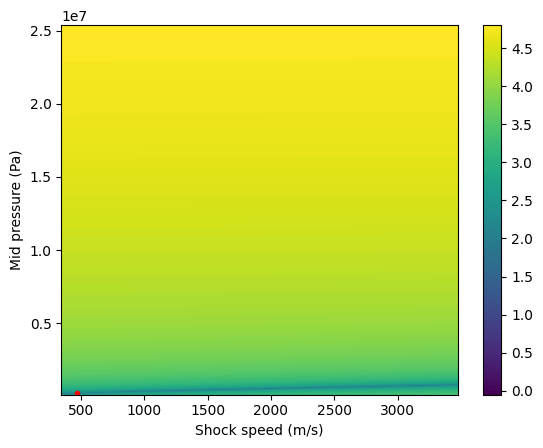

In [6]:
''' Plot norm of Rankine-Hugoniot residuals '''
plt.contourf(mg_sigma, mg_p, np.log10(mg_residuals), levels=200)
plt.colorbar()
plt.xlabel("Shock speed (m/s)")
plt.ylabel("Mid pressure (Pa)")

# Approximate minimizer
_argmin = mg_residuals.ravel().argmin()
_min_sigma, _min_p = mg_sigma.ravel()[_argmin], mg_p.ravel()[_argmin]
plt.plot(_min_sigma, _min_p, 'r.')

print(f"grid search best shock speed: {_min_sigma} (m/s)")
print(f"grid search best post-shock pressure: {_min_p} (Pa)")

In [7]:
''' Use grid search value as initial guess to fsolve '''
(sigma_solve, pP_solve), infodict, ier, mesg = scipy.optimize.fsolve(
  lambda x: compute_RH_residual(x[0], x[1], return_norm_only=False),
  np.array((_min_sigma, _min_p,)),
  full_output=True)
residual_vector = infodict["fvec"]
# Display solved shock speed, post-shock pressure, vector of Rankine-Hugoniot (momentum, energy) residuals
print(f"solved shock speed: {sigma_solve:.3f} m/s")
print(f"solved post-shock pressure: {pP_solve:.3f} Pa")
print(f"root finding fsolve residuals: {residual_vector}")

solved shock speed: 500.867 m/s
solved post-shock pressure: 227391.218 Pa
root finding fsolve residuals: [ 1.016440698272126e-10 -2.840729845415480e-12]


In [8]:
''' Compute expansion wave '''
p_in_expansion = np.linspace(pL, pP_solve, 100).ravel()
rho_in_expansion, u_in_expansion, T_in_expansion = zip(*[ruT_p(p) for p in p_in_expansion])
rho_in_expansion = np.array(rho_in_expansion)
u_in_expansion   = np.array(u_in_expansion)
T_in_expansion   = np.array(T_in_expansion)
# Expand dimensions to (-, -, -)
arhoVec_in_expansion = np.expand_dims(np.array(rho_in_expansion), axis=(1,2))* yL
phi_in_expansion = atomics.gas_volfrac(arhoVec_in_expansion, np.expand_dims(T_in_expansion, axis=(1,2)), physics)
c_in_expansion = atomics.sound_speed(GammaL, np.expand_dims(p_in_expansion, axis=(1,2)),
                                     np.expand_dims(rho_in_expansion, axis=(1,2)),
                                     phi_in_expansion, physics)
# Clean up sound speed
c_in_expansion = c_in_expansion.ravel()

In [9]:
''' Compute post-shock density '''
# Rankine-Hugoniot mass
uP_solved = float(ruT_p(pP_solve)[1])
rhoP = rhoR * (uR - sigma_solve) / (uP_solved - sigma_solve)
rhoP = float(rhoP)

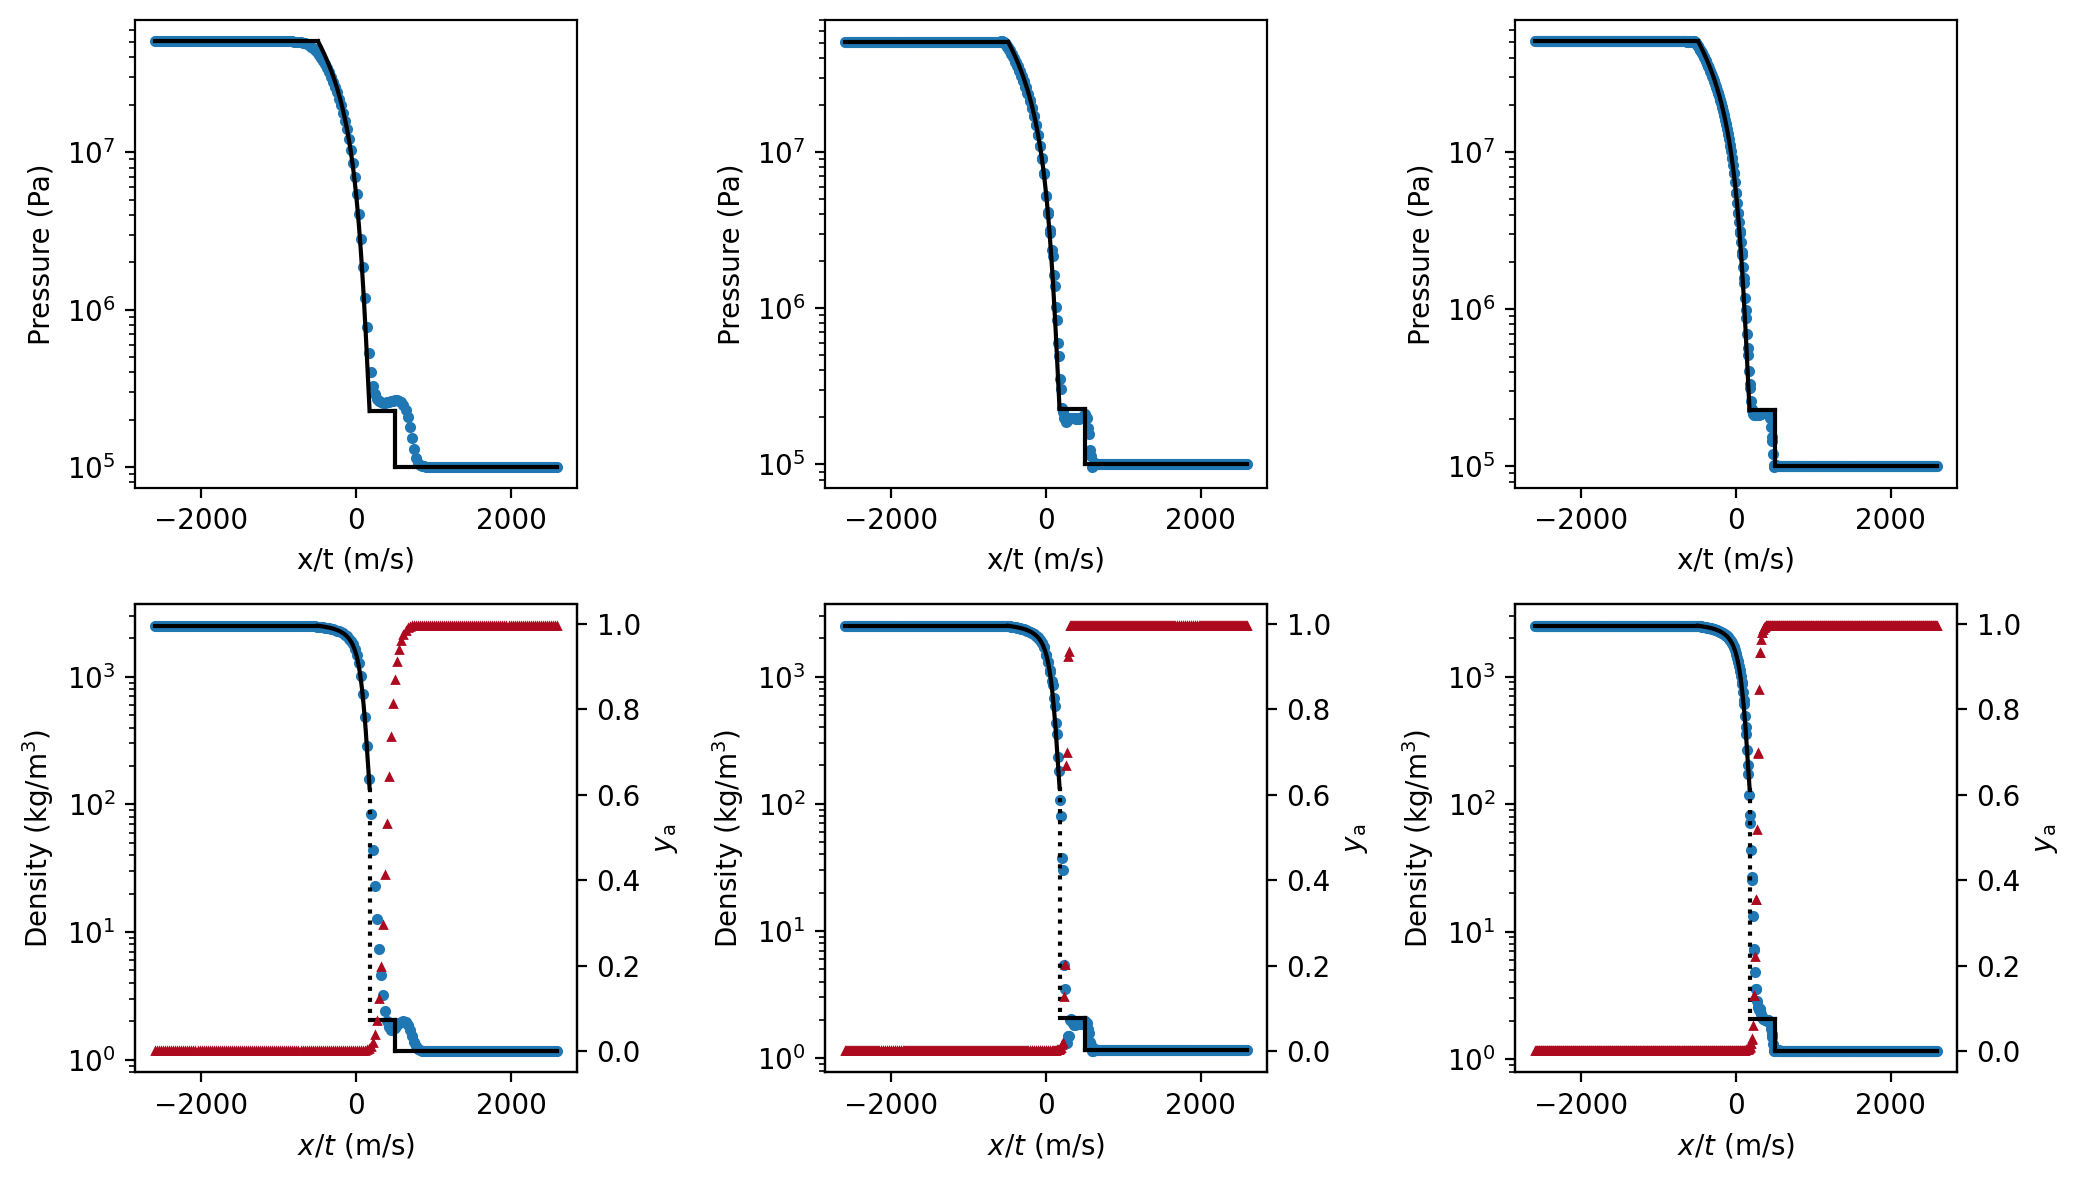

In [15]:
''' Plot generation '''

plt.figure(figsize=(10.5,6), dpi=200)
solver1D_from = lambda P, i: readwritedatafiles.read_data_file(f"sodtube_AVnonhydrostatic_p{P}_{i}.pkl")

for P in [0, 1, 2]:
  plt.subplot(2,3,P+1)
  # Extract DG solution
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  p = solver.physics.compute_variable("Pressure", U)
  rho = U[...,0:3].sum(axis=-1)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, p.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(pL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, p_in_expansion, 'k-')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, pP_solve * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(pR), pP_solve], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(pR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("x/t (m/s)")
  plt.ylabel("Pressure (Pa)")

  plt.subplot(2,3,3+P+1)
  # Extract DG solution
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, rho.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(rhoL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, rho_in_expansion, 'k-')
  # Plot material interface connector (vertical line)
  plot_tool((u_in_expansion - c_in_expansion).ravel()[-1] * np.array([1, 1]),
            [rho_in_expansion.ravel()[-1], float(rhoP)], 'k:')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, rhoP * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(rhoR), rhoP], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(rhoR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("$x/t$ (m/s)")
  plt.ylabel("Density (kg/m${}^3$)")

  ax2 = plt.gca().twinx()
  ax2.plot(x.ravel()/t, (U[...,0:1]/rho).ravel(), '^', color="#ad0a20", markersize=2.5)
  ax2.set_ylabel("$y_\mathrm{a}$")

plt.tight_layout()

plt.savefig('combined_sodproblem.eps', format='eps')
plt.savefig('combined_sodproblem.svg', format='svg')

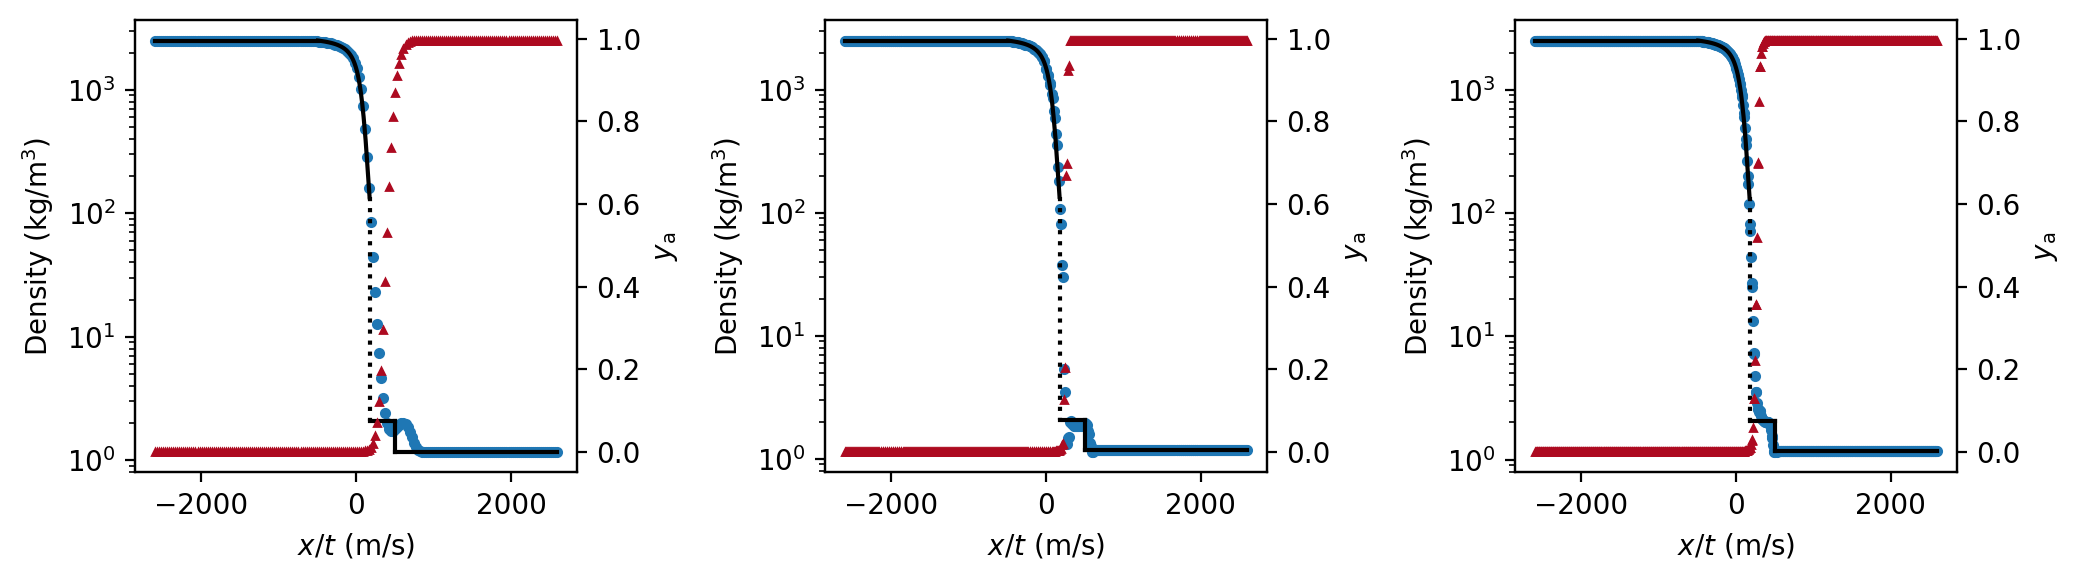

In [11]:
''' Plot generation '''

plt.figure(figsize=(10.5,3), dpi=200)
# Extract DG solution
solver1D_from = lambda P, i: readwritedatafiles.read_data_file(f"sodtube_AVnonhydrostatic_p{P}_{i}.pkl")

for P in [0, 1, 2]:
  plt.subplot(1,3,P+1)
  solver = solver1D_from(P, 16)
  t = solver.time
  U = solver.state_coeffs
  x = solver.elem_helpers.x_elems
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  # Select plot tool
  plot_tool = lambda *args: plt.semilogy(*args)
  # Plot DG solution at nodes
  plot_tool(x.ravel()/t, rho.ravel(), '.')

  ''' Exact solution '''
  # Plot pre-expansion wave
  x_min_expanded = (u_in_expansion - c_in_expansion)[0]
  x_preexpansion = np.linspace((x.ravel()/t).min(), x_min_expanded, 2)
  plot_tool(x_preexpansion, float(rhoL) * np.ones_like(x_preexpansion), 'k-')
  # Plot expansion wave
  plot_tool(u_in_expansion - c_in_expansion, rho_in_expansion, 'k-')
  # Plot material interface connector (vertical line)
  plot_tool((u_in_expansion - c_in_expansion).ravel()[-1] * np.array([1, 1]),
            [rho_in_expansion.ravel()[-1], float(rhoP)], 'k:')
  # Plot post-shock position
  x_max_expanded = (u_in_expansion - c_in_expansion)[-1]
  x_postshock = np.linspace(x_max_expanded, sigma_solve, 2)
  plot_tool(x_postshock, rhoP * np.ones_like(x_postshock), 'k-')
  # Plot shock connector (vertical line)
  plot_tool([sigma_solve, sigma_solve], [float(rhoR), rhoP], 'k-')
  # Plot pre-shock
  x_preshock = np.linspace(sigma_solve, (x.ravel()/t).max(), 2)
  plot_tool(x_preshock, float(rhoR) * np.ones_like(x_preshock), 'k-')

  # Labeling
  plt.xlabel("$x/t$ (m/s)")
  plt.ylabel("Density (kg/m${}^3$)")

  ax2 = plt.gca().twinx()
  ax2.plot(x.ravel()/t, (U[...,0:1]/rho).ravel(), '^', color="#ad0a20", markersize=2.5)
  ax2.set_ylabel("$y_\mathrm{a}$")
plt.tight_layout()

plt.savefig('rhoy_sodproblem.eps', format='eps')
plt.savefig('rhoy_sodproblem.svg', format='svg')

In [12]:
''' Compute Mach number '''
M = physics.compute_variable("XVelocity", solver.state_coeffs) / physics.compute_variable("SoundSpeed", solver.state_coeffs)
print(f"max M = {np.abs(M).max()}")

max M = 2.696023227147748
